Import des packages

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

Import du dataset et premieres analyses et data prép

In [126]:
data = pd.read_csv('maladie_cardiaque.csv', index_col='id')

In [127]:
data.drop(columns=['Unnamed: 0'],inplace=True)

In [128]:
data['age']= round(data['age']/365)

In [129]:
data.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade
id,,,,,,,,,,,,
0,50.0,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non
1,55.0,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui
2,52.0,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui
3,48.0,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui
4,48.0,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non


In [130]:
def analyse(df):
    display(f"Le dataframe est de dimension : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"]).reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name", "dtypes"]]
    summary["Missing"] = df.isnull().sum().values
    summary["Miss_Percent"] = round((summary["Missing"]*100)/df.shape[0],0)
    summary["Unique"] = df.nunique().values
    summary["First Value"] = df.iloc[0].values
    summary["Second Value"] = df.iloc[1].values
    summary["Third Value"] = df.iloc[2].values
 
    return summary

In [131]:
analyse(data)

'Le dataframe est de dimension : (70000, 12)'

,Name,dtypes,Missing,Miss_Percent,Unique,First Value,Second Value,Third Value
0,age,float64,0,0.0,28,50.0,55.0,52.0
1,genre,object,0,0.0,2,homme,femme,femme
2,taille,int64,0,0.0,109,168,156,165
3,Poids,float64,0,0.0,287,62.0,85.0,64.0
4,pression_systo,int64,0,0.0,153,110,140,130
5,pression_diasto,int64,0,0.0,157,80,90,70
6,cholesterol,object,0,0.0,3,normal,tres eleve,tres eleve
7,glycemie,int64,0,0.0,3,1,1,1
8,fumeur,object,0,0.0,2,non fumeur,non fumeur,non fumeur
9,conso_alco,object,0,0.0,2,non,non,non


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                70000 non-null  float64
 1   genre              70000 non-null  object 
 2   taille             70000 non-null  int64  
 3   Poids              70000 non-null  float64
 4   pression_systo     70000 non-null  int64  
 5   pression_diasto    70000 non-null  int64  
 6   cholesterol        70000 non-null  object 
 7   glycemie           70000 non-null  int64  
 8   fumeur             70000 non-null  object 
 9   conso_alco         70000 non-null  object 
 10  activite_physique  70000 non-null  int64  
 11  malade             70000 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 6.9+ MB


In [133]:
data.describe()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,164.359229,74.205690,128.817286,96.630414,1.226457,0.803729
std,6.765294,8.210126,14.395757,154.011419,188.472530,0.572270,0.397179
min,30.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000
50%,54.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000
max,65.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


# Data Préparation

Ajout d'une colonne avec l'IMC des individus

In [134]:
data.drop_duplicates(inplace=True)
data["IMC"] = data['Poids']/((data['taille']/100)*(data['taille']/100))
data

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,IMC
id,,,,,,,,,,,,,
0,50.0,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,21.967120
1,55.0,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,34.927679
2,52.0,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,23.507805
3,48.0,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,28.710479
4,48.0,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,53.0,homme,168,76.0,120,80,normal,1,fumeur,non,1,non,26.927438
99995,62.0,femme,158,126.0,140,90,eleve,2,non fumeur,non,1,oui,50.472681
99996,52.0,homme,183,105.0,180,90,tres eleve,1,non fumeur,oui,0,oui,31.353579


Binéarisation du genre

In [135]:
data['genre_binaire'] = data['genre'].map({'homme': 0, 'femme': 1})
data['conso_alco_binaire'] = data['conso_alco'].map({'non': 0, 'oui': 1})
data['fumeur_binaire'] = data['fumeur'].map({'non fumeur': 0, 'fumeur': 1})
data['malade_binaire'] = data['malade'].map({'non': 0, 'oui': 1})

In [136]:
data.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire
id,,,,,,,,,,,,,,,,,
0,50.0,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,21.967120,0,0,0,0
1,55.0,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,34.927679,1,0,0,1
2,52.0,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,23.507805,1,0,0,1
3,48.0,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,28.710479,0,0,0,1
4,48.0,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,23.011177,1,0,0,0


Caractérisation de l'IMC

In [137]:
labels = ['Sous-poids', 'Normal', 'Surpoids', 'Obèse']
data['IMC_Categorie'] = pd.cut(data['IMC'], bins=[0, 18.5, 25, 30, float('inf')], labels=labels, include_lowest=True)

Séparation des individus en tranche d'âge

In [138]:
bins = [0, 18, 35, 50, 70, float('inf')]
labels = ['0-18', '19-35', '36-50', '51-70', '70+']
data['Age_Categorie'] = pd.cut(data['age'], bins=bins, labels=labels, include_lowest=True)

# Analyse du dataset

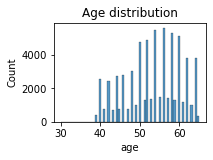

In [139]:
plt.subplot(222)
ax=sns.histplot(data['age'])
plt.title("Age distribution")
plt.show()

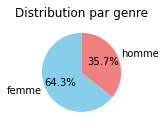

In [140]:
plt.subplot(221)
plt.title("Distribution par genre")
plt.pie(data['genre'].value_counts(), labels=data['genre'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.show()

# KNN

In [141]:
data.head()

,age,genre,taille,Poids,pression_systo,pression_diasto,cholesterol,glycemie,fumeur,conso_alco,activite_physique,malade,IMC,genre_binaire,conso_alco_binaire,fumeur_binaire,malade_binaire,IMC_Categorie,Age_Categorie
id,,,,,,,,,,,,,,,,,,,
0,50.0,homme,168,62.0,110,80,normal,1,non fumeur,non,1,non,21.967120,0,0,0,0,Normal,36-50
1,55.0,femme,156,85.0,140,90,tres eleve,1,non fumeur,non,1,oui,34.927679,1,0,0,1,Obèse,51-70
2,52.0,femme,165,64.0,130,70,tres eleve,1,non fumeur,non,0,oui,23.507805,1,0,0,1,Normal,51-70
3,48.0,homme,169,82.0,150,100,normal,1,non fumeur,non,1,oui,28.710479,0,0,0,1,Surpoids,36-50
4,48.0,femme,156,56.0,100,60,normal,1,non fumeur,non,0,non,23.011177,1,0,0,0,Normal,36-50


In [142]:
data_col = data[['age','taille','Poids','pression_systo','pression_diasto','glycemie','activite_physique','IMC','fumeur_binaire','conso_alco_binaire','malade_binaire','genre_binaire']]
data_col.head()

,age,taille,Poids,pression_systo,pression_diasto,glycemie,activite_physique,IMC,fumeur_binaire,conso_alco_binaire,malade_binaire,genre_binaire
id,,,,,,,,,,,,
0,50.0,168,62.0,110,80,1,1,21.967120,0,0,0,0
1,55.0,156,85.0,140,90,1,1,34.927679,0,0,1,1
2,52.0,165,64.0,130,70,1,0,23.507805,0,0,1,1
3,48.0,169,82.0,150,100,1,1,28.710479,0,0,1,0
4,48.0,156,56.0,100,60,1,0,23.011177,0,0,0,1


In [143]:
x = data_col.iloc[:, :-2]
y = data_col.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0, test_size = 0.2)

In [144]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

In [145]:
import math
math.sqrt(len(y_test))

115.05216208311776

In [146]:
classifier = KNeighborsClassifier(n_neighbors = 115, p = 2, metric = 'euclidean')
classifier.fit(x_train,y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=115)

In [147]:
y_pred = classifier.predict(x_test)
y_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int64)

In [148]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[2957 1878]
 [ 898 7504]]


In [149]:
print(accuracy_score(y_test,y_pred))

0.7902848077358918
